# Exercise 2 | TKO_7092 Evaluation of Machine Learning Methods 2026
## deadline: 11.2.2026 - 23:59

Regarding any questions about this exercise, please contact course assistant Jonne Pohjankukka (jjepoh@utu.fi)

********************************************

Student name: Anton Teerioja

Student number: 2214231

Student email: asteer@utu.fi

********************************************

## Water permeability prediction in forestry <br>

In this task, the client wants you to estimate the spatial prediction performance of K-nearest neighbor regression model with K=9 (9NN), using spatial leave-one-out cross-validation (i.e. SKCV, with number of folds == number of data points). The client wants you to use the C-index as the performance measure.  

In other words, the client wants you to answer the question: "What happens to the prediction performance of water permeability using 9-nearest neighbor regression model, when the geographical distance between known data and unknown data increases?".

In this task, you have three data files available (with 1691 data points): 

- input.csv, contains the 75 predictor features. 
- output.csv, contains the water permebility values. 
- coordinates.csv, contains the corresponding geographical coordinate locations of the data points. The unit of the coordinates is metre, and you can use Euclidean distance to calculate distances between the coordinate points. 

Implement the following tasks to complete this exercise:

********************************************

#### 1. Z-score standardize the predictor features (input.csv). 

#### 2. Perform spatial leave-one-out cross-validation with 9NN model for the provided data set (refer to the video lectures 3.1.3 and 3.1.4 in 'Evaluating spatial models with spatial cross-validation' for help). Estimate the water permeability prediction performance (using 9NN model and C-index) with the following distance parameter values: d = 0, 20, 40, ..., 300 (that is, 20 meter intervals from 0m to 300m). 

#### 3. When you have calculated the C-index performance measure for each value of d, visualize the results with the C-index (y-axis) as a function of d (x-axis).

********************************************

Your .ipynb-file must include the following: 

- Your own implementation of the spatial leave-one-out cross-validation for the current task. You can use third-party libraries (e.g. Scikit-learn) if you want for implementing e.g. the 9-nearest neighbor. Also, try to follow good programming practices and add comments to relevant parts of your code explaining what you are doing and why.

- Plot of the graph C-index vs. distance parameter value.

### Other guidelines on the return:

- Return your solution as a Jupyter Notebook (.ipynb) and as a PDF file generated from it. Please, add your full name to the file name.
- Make sure that the code is runnable as is.
- If AI was used, please explain at the end of the notebook, in the "AI usage disclaimer" section, how and in which parts it was applied.
- The exercise will be graded as pass/fail.
- Submit to moodle your solution on **Wednesday 11th of February** at the latest.
  
<b>Please be aware that you are required to submit your individual solution.<br> 
Submissions with identical or similar code will result in a failure for the exercise.</b>


<br><br><br>
-- START IMPLEMENTING YOUR EXERCISE AFTER THIS LINE --
<br><br><br>

### Import necessary libraries

In [1]:
# In this cell, import all the libraries that you need. For example: 
import numpy as np
import pandas as pd
import sklearn as sk
import sklearn.preprocessing as skp
import sklearn.neighbors as skn
import matplotlib.pyplot as plt

### Read in the datasets

In [2]:
# In this cell, read the files input.csv, output.csv and coordinates.csv.
# Print out the dataset dimesions (i.e. number of rows and columns).
X = pd.read_csv('input.csv', header=None)
Y = pd.read_csv('output.csv', header=None)
coordinate_data = pd.read_csv('coordinates.csv', header=None)

print(f"Input dimensions: {X.shape}")
print(f"Output dimensions: {Y.shape}")
print(f"Coordinate dimensions: {coordinate_data.shape}")

Input dimensions: (1691, 75)
Output dimensions: (1691, 1)
Coordinate dimensions: (1691, 2)


### Standardization of the predictor features (input.csv)

In [3]:
# Standardize the predictor features (input.csv) by removing the mean and scaling to unit variance. 
# In other words, z-score the predictor features. You are allowed to use third-party libraries for doing this. 
scaler = skp.StandardScaler()
scaled_X = pd.DataFrame(scaler.fit_transform(X))

In [4]:
print(scaled_X)

            0         1         2         3         4         5         6   \
0    -0.053196 -0.219296  0.210020  0.704425  0.339477  0.412638  0.331074   
1    -0.632098 -0.682804 -0.285522 -0.369542 -0.138305  2.489725  2.051755   
2    -0.674980 -0.597421 -0.568689 -0.983237 -0.828435 -0.496087 -0.451053   
3    -0.331927 -0.154649  1.307292  0.090730  0.419107  1.061728  0.956776   
4    -0.610657 -0.673046 -0.161636 -0.522966 -0.377196  0.672274  0.800351   
...        ...       ...       ...       ...       ...       ...       ...   
1686  2.316013  2.256813 -0.020053  0.551001  0.233303 -1.404813 -1.233180   
1687 -0.589216 -0.625475 -1.542075 -1.903780 -2.022890 -1.404813 -1.233180   
1688  0.472103  0.671127  0.103833  0.397577  0.100586 -0.625905 -0.607478   
1689 -0.750022 -0.734034 -1.630565 -2.057204 -2.235238 -1.404813 -1.233180   
1690 -0.567776 -0.418117 -1.135023 -1.596932 -1.704369 -1.404813 -1.233180   

            7         8         9   ...        65        66    

### Functions and analysis code

In [5]:
# Include here all the functions and other relevant code that you need in order to implement the task.

# Note! Utilize the following two functions in your implementation:

### Function for calculating C-index ###
# y: array containing true label values.
# yp: array containing the predicted label values.
def cindex(y, yp):
    n = 0
    h_num = 0 
    for i in range(0, len(y)):
        t = y[i]
        p = yp[i]
        for j in range(i+1, len(y)):
            nt = y[j]
            np = yp[j]
            if (t != nt): 
                n = n + 1
                if (p < np and t < nt) or (p > np and t > nt): 
                    h_num += 1
                elif (p == np):
                    h_num += 0.5
    return h_num/n


### Function for calculating the pairwise spatial distances between the data points ###
# The function will return a n-by-n matrix of Euclidean distances. For example, the
# distance_matrix element at indices i,j will contain the spatial distance between 
# data point i and j. Note that the element value is 0 always when i==j.
# coordinate_array: n-by-2 array containing the coordinates of the exercise data points.
def cdists(coordinate_array):
    number_of_observations = coordinate_array.shape[0]
    distance_matrix = np.zeros((number_of_observations, number_of_observations))
    for i in range(0, number_of_observations):
        distance_matrix[i, :] = np.sqrt(np.sum((coordinate_array - coordinate_array[i])**2, axis=1))
    return distance_matrix

#This is used for looping over the entire data
length = X.shape[0]

#This is used to measure distances between points
distances = cdists(coordinate_data.to_numpy())

### Results for spatial leave-one-out cross-validation with 9-nearest neighbor regression model

In [6]:
# In this cell, run your script for the Spatial leave-One-Out cross-validation 
# with 9-nearest neighbor regression model and visualize the results as 
# requested in the task assignment.

results = []

#Perform cross-validation for each order of length
for l in range(0,320, 20):
      predicted_labels = []
      true_labels = []
      
      #Testing every point each iteration
      for i in range(length):
        train_data = scaled_X
        train_labels = Y

        #Test if point is too close
        #Also removes itself because that length is always 0. This means that the
        #test data isn't in the training data
        for k in range(length):
          if(distances[i][k] <= l):
            train_data = train_data.drop(k)
            train_labels = train_labels.drop(k)

        #Using 9KNN
        knr = skn.KNeighborsRegressor(n_neighbors=9, n_jobs=-1, metric='euclidean')
        knr.fit(train_data, train_labels)
        predicted_label = knr.predict(pd.DataFrame(scaled_X.loc[i]).T)

        #Predicted and True labels are saved per length
        predicted_labels.append(predicted_label[0][0])
        true_labels.append(Y.iloc[i][0])
      
      #For every point in a length, the C-index value is calculated
      #The result is stored for future analysis
      c_index = cindex(true_labels, predicted_labels)
      results.append([l, c_index])

KeyboardInterrupt: 

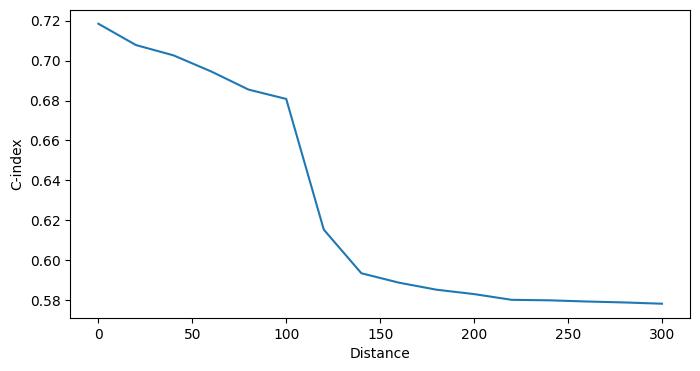

In [ ]:
results = pd.DataFrame(results, columns=['len', 'c-index'])

fig = plt.figure(figsize=(8,4))
plt.plot(results['len'], results['c-index'])
plt.xlabel('Distance')
plt.ylabel('C-index')
plt.show()

In [ ]:
print(results.sort_values('c-index', ascending=False))

    len   c-index
0     0  0.718488
1    20  0.707813
2    40  0.702640
3    60  0.694606
4    80  0.685477
5   100  0.680810
6   120  0.615356
7   140  0.593508
8   160  0.588789
9   180  0.585267
10  200  0.583063
11  220  0.580194
12  240  0.579946
13  260  0.579356
14  280  0.578883
15  300  0.578244


## Analysis of the results

### In this cell, you need to answer the client's questions:


1. What happens to the 9NN performance as the prediction distance increases?


2. Do you think the results behave as was somewhat expected? Do they make sense, why?


3. If we require that the 9NN must have at least C-index performance of 0.68, then up to what distance should we trust the 9NN predictions, based on the results?

1. The 9NN performance decreases as the distance increases. This makes intuitive sense as the fewer points are nearby
the test point the more uncertain the prediction becomes.

2. The results make sense because of spatial autocorrelation which means that nearby areas are more similar than areas far away. This means that the distance increasing should automatically decrease the accuracy of the model.

3. The answer can be estimated using the graph or by looking at the data. The 100 meter distance has the c-index score of 0.68 and the 120 meter distance has less than 0.68 as it's c-index score. Therefore we can trust distances up to 100 meters at the performance limit of 0.68

## AI usage disclaimer

In case AI was used to solve the exercise, please explain how and in which parts it was used.